In [120]:
#%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import scipy.stats as sps

# Pre-calculate some global data used by functions plot_simplex, plot_dirichlet, and plot_points_in_simplex
_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_invT = np.linalg.inv(_corners[:2]-_corners[2])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
_refiner = tri.UniformTriRefiner(_triangle)
_trimesh = _refiner.refine_triangulation(subdiv=7)
# Now convert _trimesh 2D cartesian coordinates to 3D barycentric coordinates (i.e. 3D point on the 2D simplex)
# as described in https://en.wikipedia.org/wiki/Barycentric_coordinate_system#Edge_approach
# We calculate only the first 2 barycentric coordinates as sps.dirichlet.pdf is happy without the last one (l3 = 1-l1+l2)
_tol=1.e-8
_l1l2 = (np.c_[_trimesh.x, _trimesh.y] -_corners[2]) @ _invT
_l1l2 = np.clip(_l1l2, 2*_tol, 1.0-_tol) - _tol # to make sure that none of the probabilities is exactly zero or one

def plot_simplex(class_labels=[""]*3):    
    '''Plot "axis" for 2-simplex. It simply plots a triangle into which we will be ploting points
       representing Categorical distributions (for 3 categories/topics) or a Dirichlet distribution.
    Arguments:
       class_labels: list of 3 strings that are used as labels (i.e. category/topic names) for the
       simplex (triangle) corners
    '''
    plt.triplot(_triangle, linewidth=1)
    #plt.xlim(0, 1)
    #plt.ylim(0, 0.75**0.5)
    plt.axis('equal')
    plt.axis('off')
    plt.text(0,           0, class_labels[0], horizontalalignment='left',   verticalalignment='top')
    plt.text(1,           0, class_labels[1], horizontalalignment='right',  verticalalignment='top')
    plt.text(0.5, 0.75**0.5, class_labels[2], horizontalalignment='center', verticalalignment='bottom')


def plot_dirichlet(alpha, nlevels=128, **kwargs):
    '''Plot Dirichlet pdf in an equilateral triangle (2-simplex).
    Arguments:
        alpha: Dirichlet distribution parameters.
        nlevels (int): Number of contours (shades) to draw.
        kwargs: Keyword args passed on to `plt.tricontourf`.
    '''
    plt.tricontourf(_trimesh, sps.dirichlet.pdf(_l1l2.T, alpha), nlevels, cmap='gray_r', **kwargs)
    
def plot_points_in_simplex(X, **kwargs):
    '''Plots a set of points in the 2-simplex. Each point can represent
       a categorical distribution with 3 categories/topics.
    Arguments:
        X: A Nx3 array in barycentric coordinates of points to plot.
        kwargs: Keyword args passed on to `plt.plot`.
    '''
    plt.plot(*(X @ _corners).T, **kwargs)

## Bayesian inference for Categorical distribution
$$
\DeclareMathOperator{\Dir}{Dir}
\DeclareMathOperator{\aalpha}{\boldsymbol{\alpha}}
\DeclareMathOperator{\mm}{\mathbf{m}}
\DeclareMathOperator{\Cat}{Cat}
\DeclareMathOperator{\ppi}{\boldsymbol{\pi}}
$$

Categorical distribution for categorical variable $x \in \{1, 2, \dots, C\}$ can be parametrized by vector of probabilities for individual categries $\ppi = [\pi_1, \dots, \pi_C]$
$$
\large
p(x \mid \ppi) = \Cat(x \mid \ppi) = \pi_x
$$

Dirichlet distribution can be used as conjugate prior for parameters $\ppi$ of Categorical distribution.

$$
\large
\Dir(\ppi \mid \aalpha) = \frac{\Gamma\left (\sum_{c=1}^C \alpha_c \right)}{\prod_{c=1}^C \Gamma(\alpha_c)} \prod_{c=1}^C \pi_c^{\alpha_c - 1}
$$
where $\aalpha= [\alpha_1, \alpha_2, \dots, \alpha_C]$ is the vector of prior parameters.

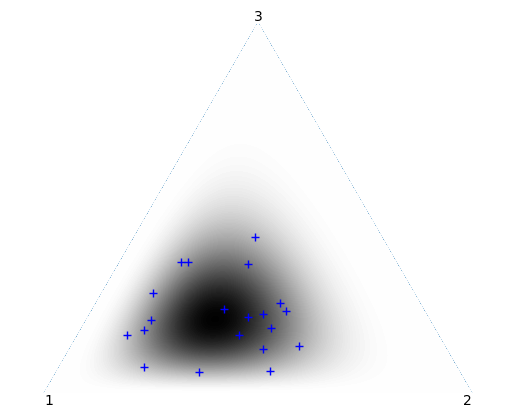

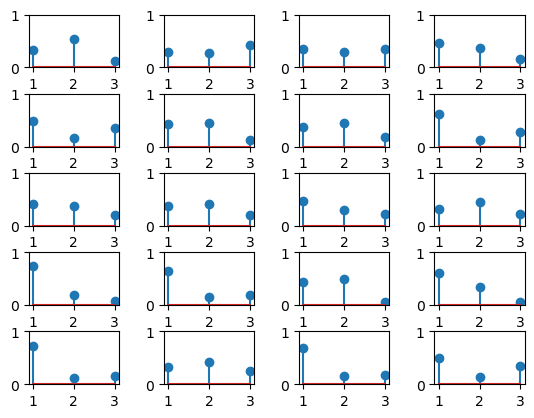

In [438]:
#Plot some example NormalGamma distribution
#alpha = [1.0, 1.0, 1.0] # flat prior
#alpha = [0.5, 0.5, 0.5] # Jeffreys prior
alpha = [6.0, 4.0, 3.0]
plot_simplex([1,2,3])
plot_dirichlet(alpha)

# Obtain few samples from the prior distribution.
pi_sampled = sps.dirichlet.rvs(alpha, 20)
plot_points_in_simplex(pi_sampled, c='b', ls='none', marker='+')

# Each of these samples represents parameters (probabilities) of a categorical distribution. We will plot them

plt.figure()
for i, pi in enumerate(pi_sampled):
    plt.subplot(5, 4, i+1)
    plt.axis([0.9, 3.1, 0, 1])
    plt.stem([1,2,3], pi)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

Given $N$ observations $\mathbf{x}=[x_1, x_2, \dots, x_N]$ from categorical distribution $\Cat(x \mid \ppi)$ and given prior $p(\ppi) = \Dir(\ppi \mid \aalpha)$ the poterior distribution over parameters $\ppi$ is:

$$
\large
p(\ppi |\mathbf{x}) = \Dir(\ppi |\aalpha + \mm)
$$, 

where

$\mm = [m_1, m_2, \dots, m_C]$ is vector of counts saying how many each category appears in the input observations $\mathbf{x}$.

Note that each $\alpha_c-1$ can be seen as prior count for observing category $c$.

Groud truth categorical distribution: [0.5, 0.3, 0.2]
Counts for observations sampled from this distribution: [7 3 0]


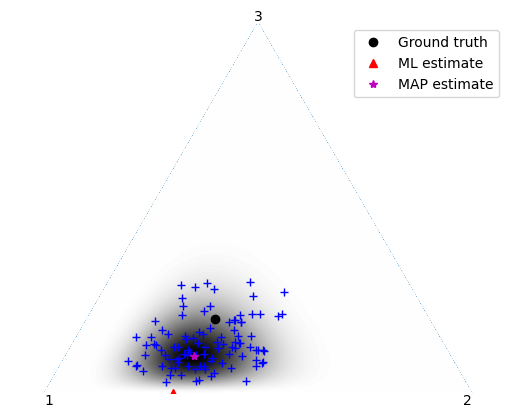

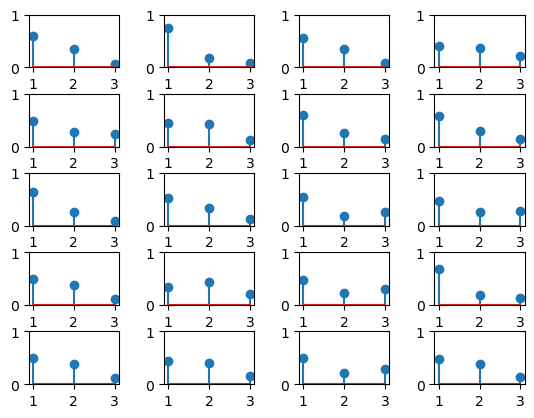

In [468]:
#Let's have a Categorical distribution, which we believe to be sampled from the above Dirichlet prior
pi = [0.5, 0.3, 0.2]

#We could actually sample it from the prior
#pi = sps.dirichlet.rvs(alpha, 1)[0]
print("Groud truth categorical distribution:", pi)

# Generate observation from a given categorical distribution and obtain the count for each category. 
#This corresponds to directly sampling from Multiomial distribution:

N = 10
m = sps.multinomial.rvs(N, pi)
print("Counts for observations sampled from this distribution:", m)

# Given Dirichlet prior and the observations (counts), calculate and plot posterior distibution of the parameters of categorical distributions
plot_simplex([1,2,3])
plot_dirichlet(alpha+m)

# Obtain few samples from the posterior distribution.
pi_sampled = sps.dirichlet.rvs(alpha+m, 100)
plot_points_in_simplex(pi_sampled, c='b', ls='none', marker='+')
plot_points_in_simplex(pi, c='k', ls='none', marker='o', label="Ground truth")
plot_points_in_simplex(m/m.sum(), c='r', ls='none', marker='^', label="ML estimate")
# Maximum of the Dirichlet posterior will be the same as ML estimate for flat prior \alpha=[1.0 1.0 1.0]
plot_points_in_simplex((alpha+m-1)/(alpha+m-1).sum(), c='m', ls='none', marker='*', label="MAP estimate") 
plt.legend()

# Each of these samples represents parameters (probabilities) of a categorical distribution that could have generated the input observations
plt.figure()
for i, p in enumerate(pi_sampled[:20]):
    plt.subplot(5, 4, i+1)
    plt.axis([0.9, 3.1, 0, 1])
    plt.stem([1,2,3], p)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

### Predictive probability

For Categorical distribution with Dirichlet prior, the posterior predictive distribution is again Categorical distribution:

$$
\large
\newcommand{\diff}{\mathop{}\!d}
\begin{align}
p(x' \mid \mathbf{x}) 
&= \int p(x'\mid\ppi) p(\ppi \mid \mathbf{x}) \diff\ppi \\
&= \int \Cat(x'\mid\ppi) \Dir(\ppi\mid \aalpha+\mm) \diff \ppi \\ 
&= \Cat\left(x'\middle| \frac{\aalpha+\mm}{\sum_{c=1}^C \alpha_c+m_c}\right) 
\end{align}
$$


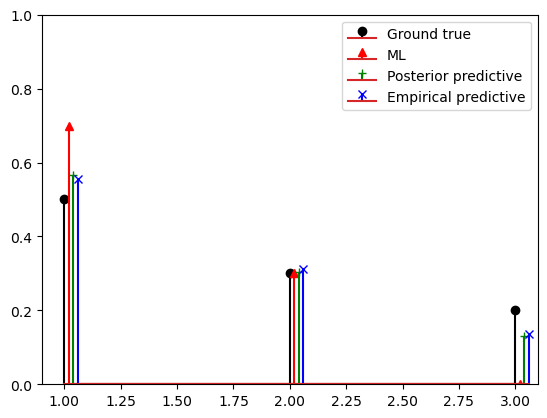

In [471]:
t = np.linspace(-5,5,1000) # x-axis for our plots
# Plot the distribution from which the observations were generated
plt.axis([0.9, 3.1, 0, 1])
plt.stem(np.array([1,2,3]), pi, 'k', markerfmt="o", label="Ground true")

# Plot the ML estimate of the Categorical  distribution
plt.stem(np.array([1,2,3])+0.02, m/m.sum(), 'r', markerfmt="^", label="ML")

# Plot predictive distribution, which depends on the prior and the observations 
# (i.e. depends on the posterior distribution over the parameters \pi)
plt.stem(np.array([1,2,3])+0.04, (alpha+m)/(alpha+m).sum(), 'g', markerfmt="+", label="Posterior predictive")

# Take all the sampled Categorical distributions from the previous figure, average them and plot the resulting distribution
# For large number of samples, this should be good approximation to the predictive distribution 
#plt.plot(t, pi_sampled.mean(axis=1))
plt.stem(np.array([1,2,3])+0.06, pi_sampled.mean(axis=0), 'b', markerfmt="x", label="Empirical predictive")
plt.legend()